Chiara Barbieri, 517096 --
Bachelor's thesis

# <center> Dataset import and preprocessing <center>


# Libraries

In [ ]:
pip install boto3 parallel_wavegan munch

In [ ]:
"""Libraries to managae directories"""
import os
import gdown
import traceback
import sys
import importlib
from pathlib import Path
from zipfile import ZipFile

"""Libraries to manage data"""
import math
import random
import argparse
import time
from tqdm import tqdm
from collections import Counter
from typing import List, Tuple, Dict, Optional, Callable

"""Libraries to manage datasets"""
import json
import tarfile
import subprocess
import pickle
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

"""Libraries to manage audios"""
import boto3
import soundfile as sf
import click
import yaml
import glob
import tensorboard
import parallel_wavegan
import pydub

import transformers
from transformers import AutoModel

import munch
from munch import Munch

"""Scipy"""
import scipy
from scipy.spatial.distance import cdist
from scipy import signal
from scipy.io import wavfile

"""Torchaudio"""
import torchaudio
import torchaudio.transforms as T
from torchaudio.functional import resample

"""Pytorch"""
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import weight_norm, remove_weight_norm
import torch.optim as optim

"""Librosa"""
import librosa
import librosa.display
from librosa.display import waveshow, specshow
import librosa.feature
import librosa.feature.inverse
import librosa.effects

"""IPython"""
import IPython
from IPython import display
from IPython.display import Audio, display

Don't run the following cell if not on Google Collaboratory:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Change to the thesis directory
os.chdir('/content/drive/MyDrive/Thesis')
print("Current directory:", os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current directory: /content/drive/MyDrive/Thesis


# Importing the dataset

The dataset that will be used is the Google Speech Command Dataset (GSCD). For this project, two versions of it will be used:
- Partial dataset with 10 classes (**GSCD-10**)
- Full dataset with 30 classes (**GSCD-30**)

The dataset was downloaded using the link:
[speech_commands_v0.01.tar.gz](http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz)

In [ ]:
# Extract the dataset from the tar.gz zipped file

try:
  # If the code is running on the local device
  tar_path = r'd:\Bachelor AI\Thesis\Coding\speech_commands_v0.01.tar.gz'
  extract_path = r'd:\Bachelor AI\Thesis\Coding\speech_commands_v0.01'
  with tarfile.open(tar_path, 'r:gz') as tar_ref:
      tar_ref.extractall(extract_path, filter='data')
except:
  # If the code is running on Google Collab
  downloaded_tar = '/content/drive/MyDrive/Thesis/speech_commands_v0.01.tar.gz'
  extract_dpath = '/content/drive/MyDrive/Thesis/speech_commands_v0.01'
  with tarfile.open(downloaded_tar, 'r:gz') as tar_ref:
      tar_ref.extractall(extract_dpath, filter='data')

To define the two datasets (GSCD-10 and GSCD-30), the *SpeechCommandsDataset* defined below was used.

In [ ]:
class SpeechCommandsDataset(Dataset):
    def __init__(self,
                folder,                     # Root folder of the dataset
                classes,                    # List of class names to include
                sample_rate=16000,          # Target sample rate
                n_mels=64,                  # Number of Mel bands
                return_waveform=False):     # If True, return raw waveform instead of spectrogram

        self.folder = folder
        self.target_sr = sample_rate
        self.return_waveform = return_waveform

        # Map class names to their indices
        self.classes = classes
        self.class_to_idx = {c: i for i, c in enumerate(classes)}

        # Collect tuples of (file_path, label)
        self.data = []

        # Collect .wav file paths and their labels
        for c in classes:
            d = os.path.join(folder, c)
            if not os.path.isdir(d):
                continue

            wav_files = [f for f in os.listdir(d) if f.lower().endswith('.wav')]
            print(f"Found {len(wav_files)} files in class '{c}'")

            for f in wav_files:
                self.data.append((os.path.join(d, f), self.class_to_idx[c]))

        if len(self.data) == 0:
            raise ValueError(f"No audio files found in {folder}! Check the path and extraction.")

        print(f"Total samples loaded: {len(self.data)}")

        # Transforms to spectrogram mode (default spectrogram)
        self.melspec = T.MelSpectrogram(sample_rate=sample_rate, n_mels=n_mels)
        self.db = T.AmplitudeToDB()

    def __len__(self):
        # Return the total number of samples (dataset size)
        return len(self.data)

    def __getitem__(self, index):
        # Load the selected sample
        path, target = self.data[index]

        # Waveform mode
        if self.return_waveform:
            wav, sr = torchaudio.load(path)
            # Convert to mono if stereo
            if wav.size(0) > 1:
                wav = wav.mean(dim=0, keepdim=True)
            # Resample to target sample rate if needed
            if sr != self.target_sr:
                wav = torchaudio.functional.resample(wav, sr, self.target_sr)
            return wav.squeeze(0), target

        # Spectrogram mode (default)
        wav, sr = torchaudio.load(path)
        # Convert to mono if stereo
        if wav.size(0) > 1:
            wav = wav.mean(dim=0, keepdim=True)
        # Resample to target sample rate if needed
        if sr != self.target_sr:
            wav = torchaudio.functional.resample(wav, sr, self.target_sr)
        # Compute Mel spectrogram and convert to dB scale
        spec = self.db(self.melspec(wav)).squeeze(0)

        return spec, target


## GSCD-10 dataset

The labels selected for the partial dataset are "yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go".

In [ ]:
# Classes present in GSCD-10
classes10 = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

# Creating dataset instances for GSCD-10
try:
  # If the code is running on the local device
  GSCD10 = SpeechCommandsDataset(folder=extract_path, classes=classes10, return_waveform=True)
except:
  # If the code is running on Google Collab
  GSCD10 = SpeechCommandsDataset(folder=extract_dpath, classes=classes10, return_waveform=True)

GSCD10

Found 2377 files in class 'yes'
Found 2375 files in class 'no'
Found 2375 files in class 'up'
Found 2359 files in class 'down'
Found 2353 files in class 'left'
Found 2367 files in class 'right'
Found 2367 files in class 'on'
Found 2357 files in class 'off'
Found 2380 files in class 'stop'
Found 2372 files in class 'go'
Total samples loaded: 23682


In [ ]:
n = 0
for i in classes10:
    print(f"At index {n} we have label: {i}")
    n += 1

At index 0 we have label: yes
At index 1 we have label: no
At index 2 we have label: up
At index 3 we have label: down
At index 4 we have label: left
At index 5 we have label: right
At index 6 we have label: on
At index 7 we have label: off
At index 8 we have label: stop
At index 9 we have label: go


In [ ]:
print("Number of classes in GSCD-10:", len(GSCD10.classes))
print("Number of samples in GSCD-10:", len(GSCD10))

Number of classes in GSCD-10: 10
Number of samples in GSCD-10: 23682


In [ ]:
# Check on the structure of a GSCD-10 sample (audio waveform, label)
GSCD10[0]

(tensor([-0.0049, -0.0064, -0.0081,  ..., -0.0032, -0.0038, -0.0052]), 0)

Text(0.5, 1.0, 'Audio Waveform')

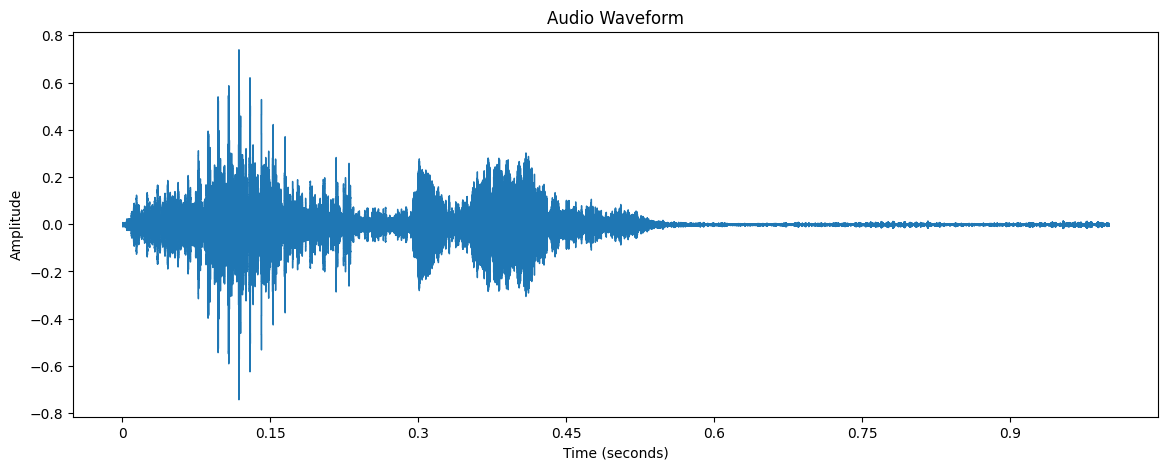

In [ ]:
# Display the waveform of the first audio sample in GSCD-10
plt.figure(figsize=(14, 5))
librosa.display.waveshow(GSCD10[0][0].numpy(), sr=16000)
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.title("Audio Waveform")

## GSCD-30 dataset

The full dataset has all the classes, so we extract them directly from the data.

In [ ]:
# Classes present in GSCD-30 (the full dataset, so all the classes present in the original dataset)

try:
  # If the code is running on the local device
  classes30 = [d for d in os.listdir(extract_path)
            if os.path.isdir(os.path.join(extract_path, d))
            and not d.startswith('_')]
  GSCD30 = SpeechCommandsDataset(folder=extract_path, classes=classes30, return_waveform=True)
except:
  # If the code is running on Google Collab
  classes30 = [d for d in os.listdir(extract_dpath)
            if os.path.isdir(os.path.join(extract_dpath, d))
            and not d.startswith('_')]
  GSCD30 = SpeechCommandsDataset(folder=extract_dpath, classes=classes30, return_waveform=True)

GSCD30

Found 2352 files in class 'eight'
Found 1734 files in class 'sheila'
Found 2364 files in class 'nine'
Found 2377 files in class 'yes'
Found 2370 files in class 'one'
Found 2375 files in class 'no'
Found 2353 files in class 'left'
Found 1733 files in class 'tree'
Found 1713 files in class 'bed'
Found 1731 files in class 'bird'
Found 2372 files in class 'go'
Found 1745 files in class 'wow'
Found 2377 files in class 'seven'
Found 1746 files in class 'marvin'
Found 1746 files in class 'dog'
Found 2356 files in class 'three'
Found 2373 files in class 'two'
Found 1750 files in class 'house'
Found 2359 files in class 'down'
Found 2369 files in class 'six'
Found 2357 files in class 'five'
Found 2357 files in class 'off'
Found 2367 files in class 'right'
Found 1733 files in class 'cat'
Found 2376 files in class 'zero'
Found 2372 files in class 'four'
Found 2380 files in class 'stop'
Found 2375 files in class 'up'
Found 2367 files in class 'on'
Found 1742 files in class 'happy'
Total samples loa

In [ ]:
n = 0
for i in classes30:
    print(f"At index {n} we have label: {i}")
    n += 1

At index 0 we have label: eight
At index 1 we have label: sheila
At index 2 we have label: nine
At index 3 we have label: yes
At index 4 we have label: one
At index 5 we have label: no
At index 6 we have label: left
At index 7 we have label: tree
At index 8 we have label: bed
At index 9 we have label: bird
At index 10 we have label: go
At index 11 we have label: wow
At index 12 we have label: seven
At index 13 we have label: marvin
At index 14 we have label: dog
At index 15 we have label: three
At index 16 we have label: two
At index 17 we have label: house
At index 18 we have label: down
At index 19 we have label: six
At index 20 we have label: five
At index 21 we have label: off
At index 22 we have label: right
At index 23 we have label: cat
At index 24 we have label: zero
At index 25 we have label: four
At index 26 we have label: stop
At index 27 we have label: up
At index 28 we have label: on
At index 29 we have label: happy


In [ ]:
print("Number of classes in GSCD-30:", len(GSCD30.classes))
print("Number of samples in GSCD-30:", len(GSCD30))

Number of classes in GSCD-30: 30
Number of samples in GSCD-30: 64721


In [ ]:
# Check on the structure of a GSCD-30 sample (audio waveform, label)
GSCD30[0]

(tensor([ 0.0044,  0.0048,  0.0056,  ..., -0.0068, -0.0059, -0.0060]), 0)

Text(0.5, 1.0, 'Audio Waveform')

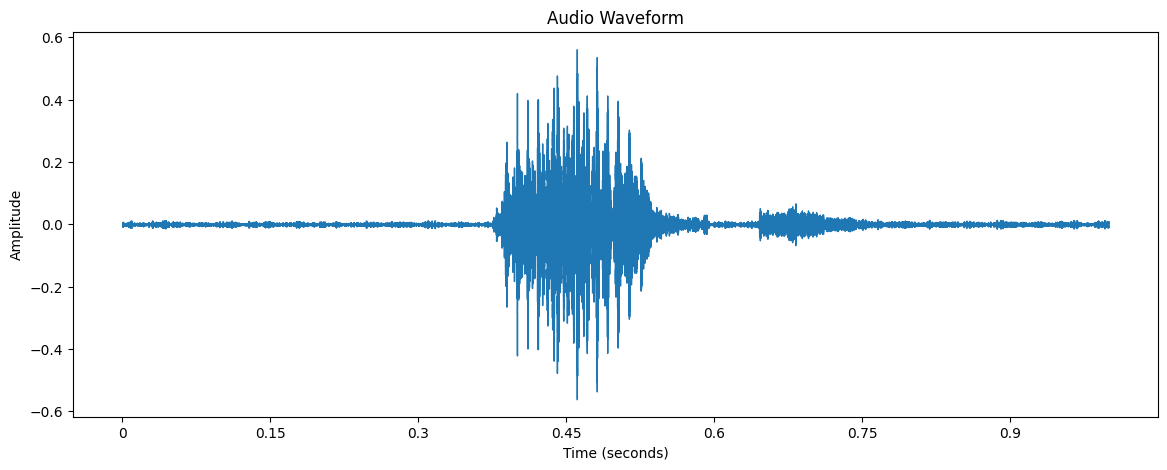

In [ ]:
# Display the waveform of the first audio sample in GSCD-30
plt.figure(figsize=(14, 5))
librosa.display.waveshow(GSCD30[0][0].numpy(), sr=16000)
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.title("Audio Waveform")

# Preprocessing the datasets

The preprocessing step applied over the datasets GSCD-10 and GSCD-30 is only for data cleaning, more specifically it only involves filtering out the audios shorter than 1 second.

In [ ]:
def clean_dataset(dataset, min_duration=1.0):
    kept = []
    for path, target in dataset.data:
        try:
            info = torchaudio.info(path)
            duration = info.num_frames / float(info.sample_rate)
            if duration >= min_duration:
                wav, sr = torchaudio.load(path)
                kept.append((wav, sr, target, path))
        except Exception as e:
            print(f"Skipping {path}: {e}")
    return kept  # Output: list of (waveform, sr, label, path) tuples

This is done in order to avoid variable-length inputs.

In [ ]:
def pack_npz(wavs, srs, labels, paths, npz_path):
    lengths = np.array([w.shape[-1] for w in wavs], dtype=np.int32)
    sr = int(np.median(srs))

    max_len = lengths.max()
    X = np.zeros((len(wavs), max_len), dtype=np.float32)
    for i, w in enumerate(wavs):
        X[i, :w.shape[-1]] = w.squeeze()

    np.savez_compressed(
        npz_path,
        waveforms=X,
        lengths=lengths,
        labels=np.array(labels, dtype=np.int64),
        sr=sr,
        paths=np.array(paths)
    )

## GSCD-10 dataset preprocessing

Apply preprocessing:

In [ ]:
# Data cleaning
GSCD10_clean = clean_dataset(GSCD10)

/tmp/ipython-input-1357575672.py:5: UserWarning: torchaudio._backend.utils.info has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  info = torchaudio.info(path)


In [ ]:
print(GSCD10_clean[0])

(tensor([[-0.0049, -0.0064, -0.0081,  ..., -0.0032, -0.0038, -0.0052]]), 16000, 0, '/content/drive/MyDrive/Thesis/speech_commands_v0.01/yes/1b88bf70_nohash_0.wav')


Save the preprocessed dataset:

In [ ]:
# Save dataset into a lighter format than JSON: NumPy compressed .npz files
npz_path10 = r"d:\\Bachelor AI\\Thesis\\Coding\\GSCD10_clean.npz"
npz_dpath10 = '/content/drive/MyDrive/Thesis/GSCD10_clean.npz'

wavs = []
srs = []
labels = []
paths = []

try:
  # If the code is running on the local device
  for wav, sr, label, path in GSCD10_clean:
      # Constraint on the wav shape (must be a torch.Tensor)
      if isinstance(wav, np.ndarray):
          wav = torch.from_numpy(wav)

      wavs.append(wav.numpy().astype(np.float32))
      srs.append(int(sr))
      labels.append(int(label))
      paths.append(path)

  pack_npz(wavs, srs, labels, paths, npz_path10)
  print("Saved dataset")
except:
  # If the code is running on Google Collab
  for wav, sr, label, path in GSCD10_clean:
      # Constraint on the wav shape (must be a torch.Tensor)
        if isinstance(wav, np.ndarray):
            wav = torch.from_numpy(wav)

        wavs.append(wav.numpy().astype(np.float32))
        srs.append(int(sr))
        labels.append(int(label))
        paths.append(path)

  pack_npz(wavs, srs, labels, paths, npz_dpath10)
  print("Saved dataset")


Saved dataset


Number of samples in the dataset after preprocessing:

In [ ]:
# Number of samples after preprocessing
print("Number of samples in GSCD-10:", len(GSCD10_clean))

Number of samples in GSCD-10: 21312


## GSCD-30 dataset preprocessing

Apply preprocessing:

In [ ]:
# Data cleaning
GSCD30_clean = clean_dataset(GSCD30)

/tmp/ipython-input-1357575672.py:5: UserWarning: torchaudio._backend.utils.info has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  info = torchaudio.info(path)


In [ ]:
print(GSCD30_clean[0])

(tensor([[ 0.0044,  0.0048,  0.0056,  ..., -0.0068, -0.0059, -0.0060]]), 16000, 0, '/content/drive/MyDrive/Thesis/speech_commands_v0.01/eight/1b88bf70_nohash_0.wav')


Save the preprocessed dataset:

In [ ]:
# Save dataset into a lighter format than JSON: NumPy compressed .npz files
npz_path30 = r"d:\\Bachelor AI\\Thesis\\Coding\\GSCD30_clean.npz"
npz_dpath30 = '/content/drive/MyDrive/Thesis/GSCD30_clean.npz'

wavs = []
srs = []
labels = []
paths = []

try:
  # If the code is running on the local device
  for wav, sr, label, path in GSCD30_clean:
      # Constraint on the wav shape (must be a torch.Tensor)
      if isinstance(wav, np.ndarray):
          wav = torch.from_numpy(wav)

      wavs.append(wav.numpy().astype(np.float32))
      srs.append(int(sr))
      labels.append(int(label))
      paths.append(path)

  pack_npz(wavs, srs, labels, paths, npz_path30)
  print("Saved dataset")
except:
  # If the code is running on Google Collab
  for wav, sr, label, path in GSCD30_clean:
      # Constraint on the wav shape (must be a torch.Tensor)
        if isinstance(wav, np.ndarray):
            wav = torch.from_numpy(wav)

        wavs.append(wav.numpy().astype(np.float32))
        srs.append(int(sr))
        labels.append(int(label))
        paths.append(path)

  pack_npz(wavs, srs, labels, paths, npz_dpath30)
  print("Saved dataset")

Saved dataset


Number of samples in the preprocessed dataset:

In [ ]:
# Number of samples after preprocessing
print("Number of samples in GSCD-30:", len(GSCD30_clean))

Number of samples in GSCD-30: 58252
